In [1]:
#import libs
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
import pickle
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import *
from keras.callbacks import EarlyStopping
from keras import regularizers,optimizers
from keras.callbacks import LearningRateScheduler
from keras import *
from keras.applications.inception_v3 import InceptionV3
import seaborn as sns
import sklearn
from sklearn.metrics import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# TRAIN_RUN

# ../input/walk_or_run_train/train/run
train_run = glob(os.path.join('/content/drive/MyDrive/run /walk_run_train/train_run', "*.png"))

# TRAIN_WALK

train_walk = glob(os.path.join('/content/drive/MyDrive/run /walk_run_train/train_walk', "*.png"))

# ADD TRAIN_WALK AND TRAIN_RUN INTO A DATAFRAME

train = pd.DataFrame()
train['file'] = train_run + train_walk
train.head()
train

,file
0,/content/drive/MyDrive/run /walk_run_train/tra...
1,/content/drive/MyDrive/run /walk_run_train/tra...
2,/content/drive/MyDrive/run /walk_run_train/tra...
3,/content/drive/MyDrive/run /walk_run_train/tra...
4,/content/drive/MyDrive/run /walk_run_train/tra...
...,...
595,/content/drive/MyDrive/run /walk_run_train/tra...
596,/content/drive/MyDrive/run /walk_run_train/tra...
597,/content/drive/MyDrive/run /walk_run_train/tra...
598,/content/drive/MyDrive/run /walk_run_train/tra...


In [34]:
# TEST_RUN

# ../input/walk_or_run_train/train/run
test_run = glob(os.path.join('/content/drive/MyDrive/run /walk_run_test/run_test', "*.png"))

# TRAIN_WALK

test_walk = glob(os.path.join('/content/drive/MyDrive/run /walk_run_test/walk_test', "*.png"))

# ADD TRAIN_WALK AND TRAIN_RUN INTO A DATAFRAME

test = pd.DataFrame()
test['file'] = test_run + test_walk
test.head()
test

,file
0,/content/drive/MyDrive/run /walk_run_test/run_...
1,/content/drive/MyDrive/run /walk_run_test/run_...
2,/content/drive/MyDrive/run /walk_run_test/run_...
3,/content/drive/MyDrive/run /walk_run_test/run_...
4,/content/drive/MyDrive/run /walk_run_test/run_...
...,...
136,/content/drive/MyDrive/run /walk_run_test/walk...
137,/content/drive/MyDrive/run /walk_run_test/walk...
138,/content/drive/MyDrive/run /walk_run_test/walk...
139,/content/drive/MyDrive/run /walk_run_test/walk...


In [35]:
#TRAIN LABELS

train['label'] = [1 if i in train_run else 0 for i in train['file']]
train.head()

,file,label
0,/content/drive/MyDrive/run /walk_run_train/tra...,1
1,/content/drive/MyDrive/run /walk_run_train/tra...,1
2,/content/drive/MyDrive/run /walk_run_train/tra...,1
3,/content/drive/MyDrive/run /walk_run_train/tra...,1
4,/content/drive/MyDrive/run /walk_run_train/tra...,1


In [36]:
#TEST LABELS

test['label'] = [1 if i in test_run else 0 for i in test['file']]
test.head()

,file,label
0,/content/drive/MyDrive/run /walk_run_test/run_...,1
1,/content/drive/MyDrive/run /walk_run_test/run_...,1
2,/content/drive/MyDrive/run /walk_run_test/run_...,1
3,/content/drive/MyDrive/run /walk_run_test/run_...,1
4,/content/drive/MyDrive/run /walk_run_test/run_...,1


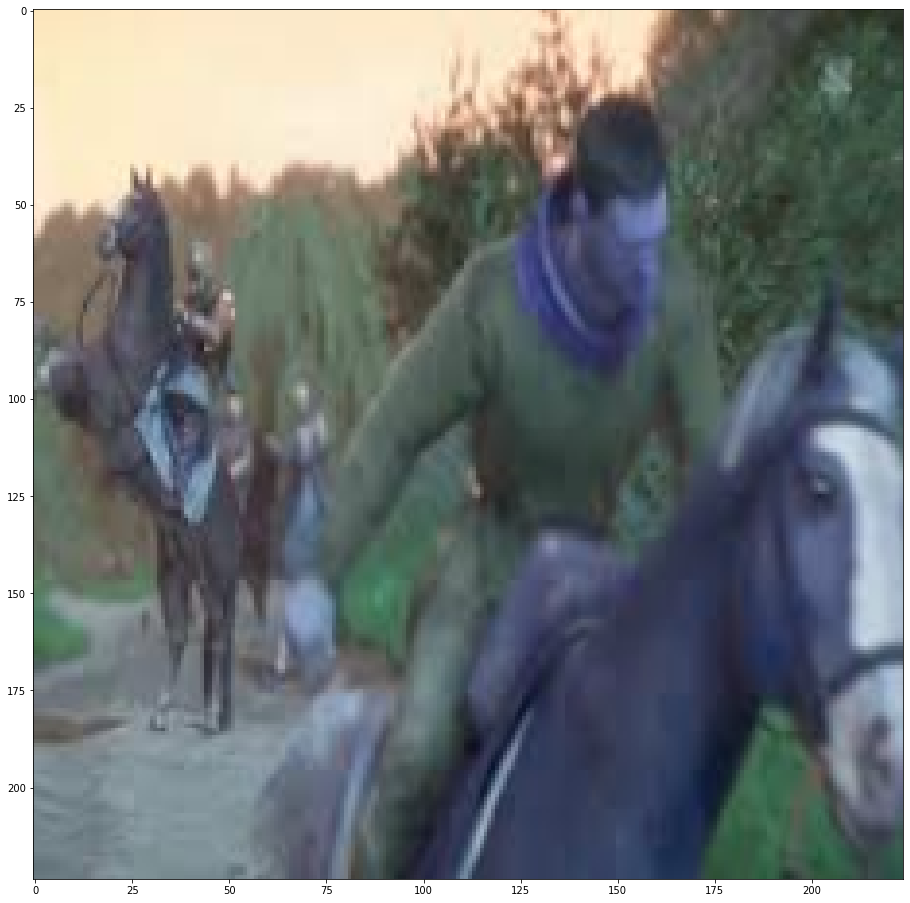

In [37]:
# TRAIN RUN AND WALK IMAGES
plt.figure(figsize=(16,16))
plt.imshow(cv2.imread(train_run[0]))


In [38]:
def dataug(files, labels, batch_size=10,randomized=True, random_seed=1):
    randomizer = np.random.RandomState(random_seed)
    img_batch = []
    label_batch = []
    while True:
        ind = np.arange(len(files))
        if randomized:
            randomizer.shuffle(ind)
        for index in ind:
            image = cv2.imread(files[index])[:,:,0:3]/255
            label = labels[index]
            img_batch.append(image)
            label_batch.append(label)
            if len(img_batch) == batch_size:
                yield np.array(img_batch), np.array(label_batch)
                img_batch = []
                label_batch = []
        
        if len(img_batch) > 0:
                yield np.array(img_batch), np.array(label_batch)
                img_batch = []
                label_batch = []

In [39]:
transfered=InceptionV3(include_top=False,weights='imagenet',input_tensor=None,input_shape=(None,None,3),pooling='avg',classes=1000)
model=Sequential()
model.add((InputLayer(None,None,3)))
model.add(transfered)
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

87924736/87910968 [==============================] - 1s 0us/step


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [43]:
transfered.trainable=False
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
batch_size=500
epochs=50

In [46]:
model.fit(dataug(train['file'],train['label'],batch_size=batch_size,randomized=True,random_seed=1),steps_per_epoch=int(np.ceil(len(train)/batch_size)), epochs=epochs,
          validation_data=dataug(test['file'],test['label'],batch_size=batch_size,randomized=True),validation_steps=int(np.ceil(len(test)/batch_size)),
          callbacks=[ModelCheckpoint(filepath='./weights.hdf5',monitor='val_loss',verbose=1,save_best_only=True)],
          verbose=1)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.7800 - acc: 0.5317
Epoch 1: val_loss improved from inf to 0.77363, saving model to ./weights.hdf5
2/2 [==============================] - 43s 42s/step - loss: 0.7800 - acc: 0.5317 - val_loss: 0.7736 - val_acc: 0.4326
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.7913 - acc: 0.5133
Epoch 2: val_loss improved from 0.77363 to 0.70693, saving model to ./weights.hdf5
2/2 [==============================] - 5s 4s/step - loss: 0.7913 - acc: 0.5133 - val_loss: 0.7069 - val_acc: 0.5177
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.7431 - acc: 0.4983
Epoch 3: val_loss improved from 0.70693 to 0.68338, saving model to ./weights.hdf5
2/2 [==============================] - 5s 4s/step - loss: 0.7431 - acc: 0.4983 - val_loss: 0.6834 - val_acc: 0.5461
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.7651 - acc: 0.5167
Epoch 4: val_loss improved from 0.68338 to 0.68222, savin

In [49]:
from keras.models import load_model

model = load_model('./weights.hdf5')

In [50]:
transfered.trainable=True
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
batch_size=500
epochs=5

In [52]:
model.fit(dataug(train['file'],train['label'],batch_size=batch_size,randomized=True,random_seed=1),steps_per_epoch=int(np.ceil(len(train)/batch_size)), epochs=epochs,
          validation_data=dataug(test['file'],test['label'],batch_size=batch_size,randomized=True),validation_steps=int(np.ceil(len(test)/batch_size)),
          callbacks=[ModelCheckpoint(filepath='./weights.hdf5',monitor='val_loss',verbose=1,save_best_only=True)],
          verbose=1)
model.load_weights('weights.hdf5')

Epoch 1/5
2/2 [==============================] - ETA: 0s - loss: 0.7514 - acc: 0.5250
Epoch 1: val_loss improved from inf to 0.69814, saving model to ./weights.hdf5
2/2 [==============================] - 5s 4s/step - loss: 0.7514 - acc: 0.5250 - val_loss: 0.6981 - val_acc: 0.5390
Epoch 2/5
2/2 [==============================] - ETA: 0s - loss: 0.7389 - acc: 0.5250
Epoch 2: val_loss did not improve from 0.69814
2/2 [==============================] - 6s 3s/step - loss: 0.7389 - acc: 0.5250 - val_loss: 0.7225 - val_acc: 0.4894
Epoch 3/5
2/2 [==============================] - ETA: 0s - loss: 0.7324 - acc: 0.5550
Epoch 3: val_loss did not improve from 0.69814
2/2 [==============================] - 6s 3s/step - loss: 0.7324 - acc: 0.5550 - val_loss: 0.7159 - val_acc: 0.5461
Epoch 4/5
2/2 [==============================] - ETA: 0s - loss: 0.7282 - acc: 0.5250
Epoch 4: val_loss did not improve from 0.69814
2/2 [==============================] - 6s 3s/step - loss: 0.7282 - acc: 0.5250 - val_los

In [53]:
model.save('model_final.h5')